In [11]:
from Quantum_Games import player, game_circuit, get_aer_result
import numpy as np

In [12]:
class iterative_player(player):
    def update_probabilities(self,
                          result,
                          values, 
                          probability_of_random
                          ):
        if np.random.random()>probability_of_random:
            average_payoff = result[self.name].mean()
            previous_strategy = self.strategy_history[-1].params[0]

            r, t, s, p = values

            if previous_strategy == 'I':
                if average_payoff == r:
                    probs = [1, 0, 0, 0]
                else:
                    probs = [0, 0.5, 0.5, 0]

            if (previous_strategy == 'X') or (previous_strategy=='Y'):
                if average_payoff == r:
                    probs = [0, 0, 0, 0]
                    probs[self.strategies.index(self.strategy_history[-1])] = 1
                else:
                    probs = [0, 0.5, 0.5, 0]
        else:
            probs = [0.25, 0.25, 0.25, 0.25]
        
        self.probabilities = probs

In [13]:
from qiskit.circuit.library import PauliGate

strategies = [PauliGate('I'), PauliGate('X'), PauliGate('Y'), PauliGate('Y')]

In [14]:
import pandas as pd

def two_player_prisoners_dilemma_payoff(results_df: pd.DataFrame, 
                                        values : list):
    # Define payoff matrix
    r, t, s, p = values
    payoff_matrix = [[(r,r), (s,t)],
                     [(t,s), (p, p)]]

    # Create payoff Dataframe
    payoff_df = results_df.copy()

    # Assign player names to the variables p1 and p2
    p1 = results_df.columns[0]
    p2 = results_df.columns[1]

    for shot in results_df.iterrows():
        # Determine the circuit result for each player
        p1_result = int(shot[1][p1])
        p2_result = int(shot[1][p2])

        # Look up payoffs in the payoff matrix
        payoffs = payoff_matrix[p1_result][p2_result]

        # Assing the resulting payoff to the proper row in the Dataframe
        payoff_df.at[shot[0], p1] = payoffs[0]
        payoff_df.at[shot[0], p2] = payoffs[1]

    return payoff_df

In [ ]:
num_iterations = 100 # Number of iterations of the game we will play
values = [3, 5, 0, 1] # values that determne the payoff matrix as seen in the previous cell
p_of_rand = 0.5 # probability that a player ignores the iterative strategy and plays randomly

# create players
alice = iterative_player('alice', strategies=strategies, probabilities=[1,0,0,0])
bob = iterative_player('bob', strategies=strategies, probabilities=[1,0,0,0])

players = [alice, bob]

payoffs = pd.DataFrame(columns=[player.name for player in players])

for _ in range(num_iterations):
    # play one iteration of the game
    circuit = game_circuit(players)
    result = get_aer_result(circuit, num_shots=1)
    #add the results from one iteration to the full results dataframe
    payoffs = pd.concat([payoffs, two_player_prisoners_dilemma_payoff(result, values)], ignore_index=True)
    
    for p in players:
        # calculate each players next move
        p.update_probabilities(result=payoffs, values=values, probability_of_random=p_of_rand)

In [26]:
payoffs.describe()

,alice,bob
count,100,100
unique,4,4
top,3,3
freq,39,39


In [ ]:
stock_prices = []
stock_price = 1.0

# Convert the outcome of each iteration of the game to a change in stock price

for row_sum in payoffs.sum(axis=1):
    if row_sum == 6:
        stock_price *= 1.0006
        stock_prices.append(stock_price)

    if row_sum == 5:
        stock_price *= 1.0002
        stock_prices.append(stock_price)

    if row_sum == 2:
        stock_price *= 0.9996
        stock_prices.append(stock_price)

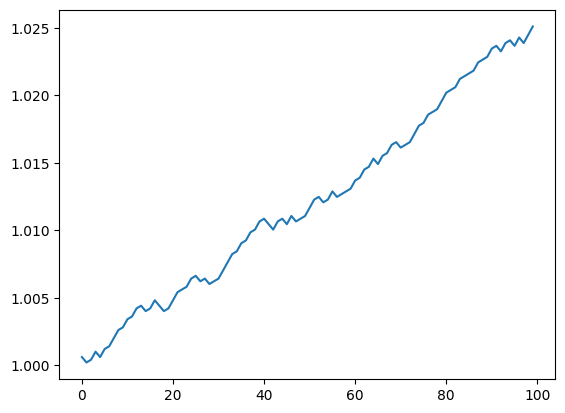

In [32]:
import matplotlib.pyplot as plt

plt.plot(stock_prices)